# Parallel Jobs

## Example: Airport monitoring

- Get a Sentinel-2 clipped image for 10 airports in a country. 
- Run all jobs in parallel
- Visualize the results

In [2]:
import up42
import pandas as pd
import geopandas as gpd
from pathlib import Path

### Random airports in Spain

Airport locations scrapped from: https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat

In [31]:
country = "Spain"

dat = "https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat"
airports = pd.read_table(dat, 
                         sep=",", 
                         usecols=[0, 1, 3, 6, 7], 
                         names=["uid",'airport', "country", "lat", "lon"])
airports = airports[airports.country==country]
airports = gpd.GeoDataFrame(airports, geometry=gpd.points_from_xy(airports.lon, airports.lat))

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world[world.name == country]
airports = airports[airports.within(world.iloc[0].geometry)]

display(airports.head())

,uid,airport,country,lat,lon,geometry
1180,1211,Albacete-Los Llanos Airport,Spain,38.948502,-1.863520,POINT (-1.86352 38.94850)
1181,1212,Alicante International Airport,Spain,38.282200,-0.558156,POINT (-0.55816 38.28220)
1182,1213,Almería International Airport,Spain,36.843899,-2.370100,POINT (-2.37010 36.84390)
1183,1214,Asturias Airport,Spain,43.563599,-6.034620,POINT (-6.03462 43.56360)
1184,1215,Córdoba Airport,Spain,37.841999,-4.848880,POINT (-4.84888 37.84200)


In [32]:
airports=airports.sample(7)

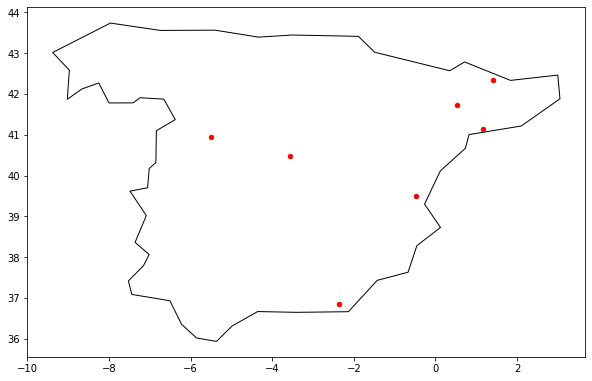

In [33]:
# Visualize locations
ax = world.plot(figsize=(10,10), color='white', edgecolor='black')
airports.plot(markersize=20, ax=ax, color="r")

In [34]:
# Buffer airport point locations by roughly 100m
airports.geometry = airports.geometry.buffer(0.001)

### Prepare UP42 workflows

Create a new project on UP42 or use an existing one.

In [3]:
# Authenticate with UP42
up42.authenticate(project_id="123456", project_api_key="123456")
#up42.authenticate(cfg_file="config.json")

project = up42.initialize_project()

2020-05-14 13:50:17,691 - up42.auth - INFO - Authentication with UP42 successful!
2020-05-14 13:50:17,692 - up42 - INFO - Working on Project with project_id d3ea9123-2b89-4975-be16-e978fed8329c


In [4]:
# Increase the parallel job limit for the project.
# Only works when you have added your credit card information to the UP42 account.
project.update_project_settings(max_concurrent_jobs=10)

2020-05-14 13:50:38,293 - up42.project - INFO - Updated project settings: [{'name': 'JOB_QUERY_MAX_AOI_SIZE', 'value': '100'}, {'name': 'MAX_CONCURRENT_JOBS', 'value': '10'}, {'name': 'JOB_QUERY_LIMIT_PARAMETER_MAX_VALUE', 'value': '10'}]


In [5]:
workflow = project.create_workflow("workflow_airports", use_existing=True)

2020-05-14 13:50:39,219 - up42.project - INFO - Getting existing workflows in project ...
2020-05-14 13:50:39,673 - up42.project - INFO - Got 9 workflows for project d3ea9123-2b89-4975-be16-e978fed8329c.
100%|██████████| 9/9 [00:03<00:00,  2.34it/s]
2020-05-14 13:50:43,539 - up42.project - INFO - Using existing workflow: workflow_airports, ecda9673-1c39-4404-948d-e707af7780c9.


In [6]:
# Fill the workflow with tasks
blocks = up42.get_blocks(basic=True)

selected_block = "sobloo-s2-l1c-aoiclipped"
workflow.add_workflow_tasks([selected_block])

workflow.get_workflow_tasks(basic=True)

2020-05-14 13:50:46,096 - up42.tools - INFO - Getting blocks name and id, use basic=False for all block details.
2020-05-14 13:50:47,349 - up42.workflow - INFO - Added tasks to workflow: [{'name': 'sobloo-s2-l1c-aoiclipped:1', 'parentName': None, 'blockId': 'a2daaab4-196d-4226-a018-a810444dcad1'}]
2020-05-14 13:50:47,880 - up42.workflow - INFO - Got 1 tasks/blocks in workflow ecda9673-1c39-4404-948d-e707af7780c9.


{'sobloo-s2-l1c-aoiclipped:1': '156fa04b-7632-4e1b-b7eb-d6c77b46a284'}

### Run jobs in parallel

Queries & downloads one image per airport in parallel.

Crude, this will soon be available in the API in one simple command!

In [39]:
# Run jobs in parallel
up42.settings(log=False)

jobs = []
for airport in airports.geometry:
    input_parameters = workflow.construct_parameters(geometry=airport, geometry_operation="bbox")
    input_parameters[f"{selected_block}:1"]["max_cloud_cover"] = 10
    
    job = workflow.run_job(input_parameters=input_parameters)
    jobs.append(job)
    
# Track status until the last job is finished.
for job in jobs:
    job.track_status(report_time=20)

In [49]:
# Download results:
out_filepaths=[]
for job in jobs:
    fp = job.download_results()
    out_filepaths.append(fp[0])

121it [00:00, 72939.18it/s]
135it [00:00, 75922.64it/s]
111it [00:00, 60104.28it/s]
202it [00:00, 98106.69it/s]
168it [00:00, 130441.15it/s]
183it [00:00, 91441.22it/s]
89it [00:00, 59765.14it/s]


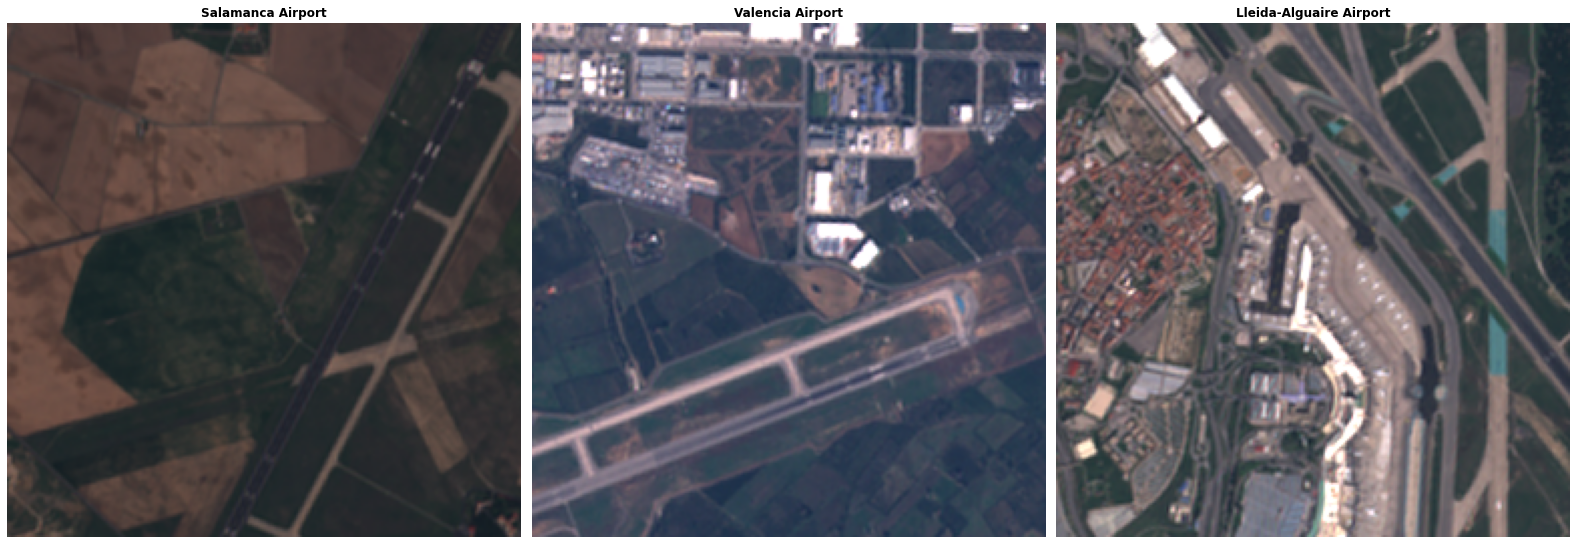

In [48]:
# Visualize downloaded results
up42.plot_results(figsize=(22,22), filepaths=out_filepaths, titles=airports.airport.to_list())